# Three Body Work-Precision Diagrams

##  Based on
https://github.com/JuliaDiffEq/DiffEqBenchmarks.jl/blob/master/notebook/NonStiffODE/ThreeBody_wpd.ipynb 

In [2]:
using Pkg
using OrdinaryDiffEq,IRKGaussLegendre,Plots,DiffEqDevTools

## Define the ThreeBody Problem

In [3]:
const threebody_μ = parse(Float64,"0.012277471")
const threebody_μ′ = 1 - threebody_μ

f = (du,u,p,t) -> begin
  @inbounds begin
  # 1 = y₁
  # 2 = y₂
  # 3 = y₁'
  # 4 = y₂'
  D₁ = ((u[1]+threebody_μ)^2 + u[2]^2)^(3/2)
  D₂ = ((u[1]-threebody_μ′)^2 + u[2]^2)^(3/2)
  du[1] = u[3]
  du[2] = u[4]
  du[3] = u[1] + 2u[4] - threebody_μ′*(u[1]+threebody_μ)/D₁ - threebody_μ*(u[1]-threebody_μ′)/D₂
  du[4] = u[2] - 2u[3] - threebody_μ′*u[2]/D₁ - threebody_μ*u[2]/D₂
  end
end

t₀ = 0.0; T = parse(Float64,"17.0652165601579625588917206249")
tspan = (t₀,2T)

prob = ODEProblem(f,[0.994, 0.0, 0.0, parse(Float64,"-2.00158510637908252240537862224")],tspan)

test_sol = TestSolution(T,[prob.u0])
#abstols = 1.0 ./ 10.0 .^ (3:13); reltols = 1.0 ./ 10.0 .^ (0:10);

In [23]:
abstols = 1.0 ./ 10.0 .^ (9:16)
reltols = 1.0 ./ 10.0 .^ (9:16)
@show abstols
@show reltols;

abstols = [1.0e-9, 1.0e-10, 1.0e-11, 1.0e-12, 1.0e-13, 1.0e-14, 1.0e-15, 1.0e-16]
reltols = [1.0e-9, 1.0e-10, 1.0e-11, 1.0e-12, 1.0e-13, 1.0e-14, 1.0e-15, 1.0e-16]


See that it's periodic in the chosen timespan:

In [24]:
sol = solve(prob,Vern9(),abstol=1e-14,reltol=1e-14)
@show sol[1] - sol[end]
@show sol[end] - prob.u0;

sol[1] - sol[end] = [-2.7379654099490836e-11, -8.161904230816544e-11, -1.3315526556367807e-8, -4.261521802106927e-9]
sol[end] - prob.u0 = [2.7379654099490836e-11, 8.161904230816544e-11, 1.3315526556367807e-8, 4.261521802106927e-9]


In [25]:
apr = appxtrue(sol,test_sol)
@show sol[end]
@show apr.u[end]
@show apr.errors

sol[end] = [0.9940000000273796, 8.161904230816544e-11, 1.3315526556367807e-8, -2.0015851021175606]
apr.u[end] = [0.9940000000273796, 8.161904230816544e-11, 1.3315526556367807e-8, -2.0015851021175606]
apr.errors = Dict(:final => 4.4215117637205975e-9)


Dict{Symbol,Float64} with 1 entry:
  :final => 4.42151e-9

## IRKGL16 Fixed-Step 

In [26]:
n=10000
dt=(tspan[2]-tspan[1])/n
(sol1,iters) = @time(solve(prob,IRKGL16(),dt=dt,saveat=10*dt,
                           adaptive=false,myoutputs=true));

  0.090708 seconds (3.56 k allocations: 243.109 KiB)


In [27]:
@show dt
@show length(sol1.t)
@show sol1[1] - sol1[end]

dt = 0.003413043312031593
length(sol1.t) = 1001
sol1[1] - sol1[end] = [-9.479300455694784e-9, -2.8136431658207892e-8, -4.590875062451143e-6, -1.475433982989216e-6]


4-element Array{Float64,1}:
 -9.479300455694784e-9 
 -2.8136431658207892e-8
 -4.590875062451143e-6 
 -1.475433982989216e-6 

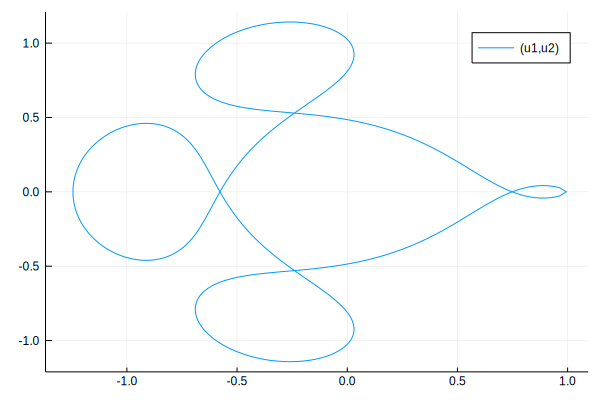

In [28]:
plot(sol1,vars=(1,2))

## IRKGL16 Adaptive-Step 

In [29]:
n=10000
dt=(tspan[2]-tspan[1])/n
(sol2,iters2,steps2,rejects2) = @time(solve(prob,IRKGL16(),dt=dt,reltol=1e-12, abstol=1e-12,
                                      adaptive=true,myoutputs=true));

  0.011097 seconds (11.12 k allocations: 982.297 KiB)


In [30]:
@show length(sol2.t)
@show sol2[1] - sol2[end]

length(sol2.t) = 139
sol2[1] - sol2[end] = [-3.74378306133849e-12, -1.1096201172882677e-11, -1.8105896030712657e-9, -5.827169857752779e-10]


4-element Array{Float64,1}:
 -3.74378306133849e-12  
 -1.1096201172882677e-11
 -1.8105896030712657e-9 
 -5.827169857752779e-10 

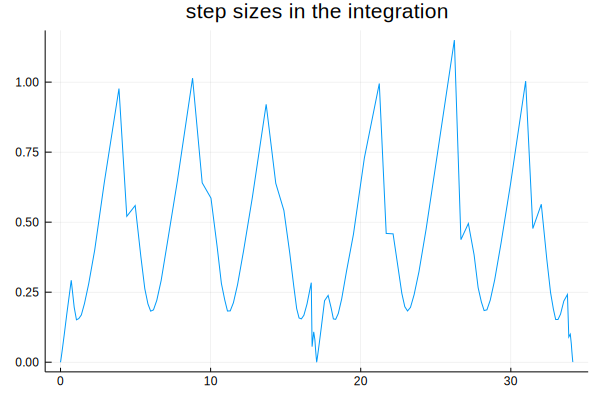

In [31]:
plot(sol2.t,steps2, title="step sizes in the integration", legend=false)

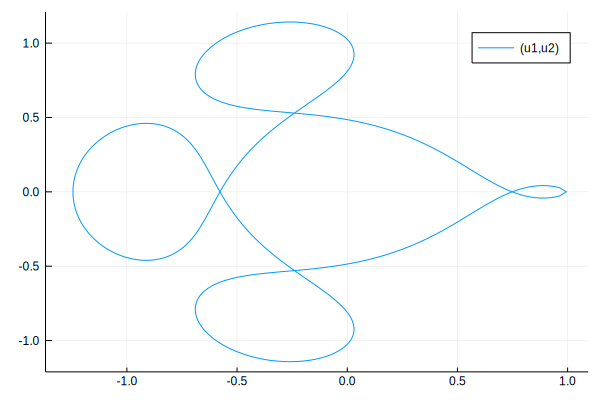

In [32]:
plot(sol1,vars=(1,2))

In [33]:
apr = appxtrue(sol2,test_sol)
@show sol2[end]
@show apr.u[end]
@show apr.errors

sol2[end] = [0.9940000000037438, 1.1096201172882677e-11, 1.8105896030712657e-9, -2.0015851057963654]
apr.u[end] = [0.9940000000037438, 1.1096201172882677e-11, 1.8105896030712657e-9, -2.0015851057963654]
apr.errors = Dict(:final => 6.020366432701912e-10)


Dict{Symbol,Float64} with 1 entry:
  :final => 6.02037e-10

## Higher Order Algorithms

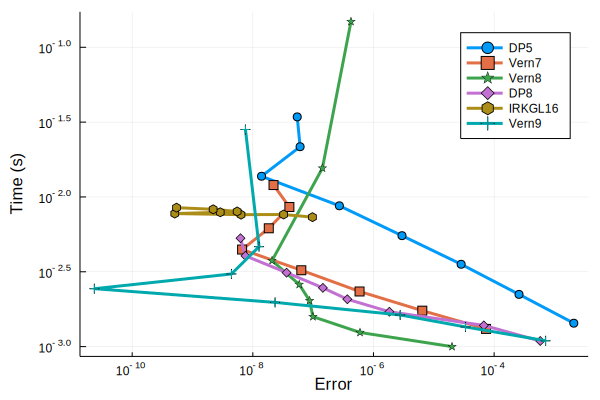

In [34]:
setups = [Dict(:alg=>DP5())
          Dict(:alg=>Vern7())
          Dict(:alg=>Vern8())
          Dict(:alg=>DP8())
          Dict(:alg=>IRKGL16())   
          Dict(:alg=>Vern9())];
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=100)
plot(wp)